In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model, Model
from keras.layers import Dense, Conv1D, GRU, Attention, Input, LSTM
from keras.callbacks import EarlyStopping

In [28]:
tf.__version__

'2.14.0'

In [29]:
# dirs
DATA_DIR = "./load.csv"
TEST_PLOT_DIR = "./test_plots/GRU/"
MODEL_FILE_DIR = "./model/GRU.keras"
TRAINING_HISTORY_DIR = "./training_history/GRU.png"

In [30]:
# constants
PREDICT_STEP = 10
INPUT_STEP = 192

N_FEATURE = 1
N_OUPUT = 1

In [31]:
if not os.path.exists(TEST_PLOT_DIR):
    os.makedirs(TEST_PLOT_DIR)
if not os.path.exists("./model"):
    os.makedirs("./model")
if not os.path.exists("./training_history"):
    os.makedirs("./training_history")


In [32]:
# Function to split data into train, validation, and test sets
def split_data(df, train_frac=0.75, test_frac=0.15):
    # Sort data by year_month
    grouped = df.groupby('year_month')

    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    val_data = pd.DataFrame()

    for name, group in grouped:
        n = len(group)
        train_end = int(train_frac * n)
        test_end = train_end + int(test_frac * n)   
        train_data = pd.concat([train_data, group.iloc[:train_end]], ignore_index=True)
        val_data = pd.concat([val_data, group.iloc[train_end:test_end]], ignore_index=True)
        test_data = pd.concat([test_data, group.iloc[test_end:]], ignore_index=True)
    # adding time_idx
    train_data['time_idx'] = np.arange(len(train_data))
    test_data['time_idx'] = np.arange(len(test_data))
    val_data['time_idx'] = np.arange(len(val_data))
    return train_data, test_data, val_data

In [33]:
def create_dataset(dataset, look_back, look_forward):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_forward+1):
        X = dataset[i:(i+look_back), :]
        y = dataset[(i+look_back):(i+look_back+look_forward), 0]
        dataX.append(X)
        dataY.append(y)
    return np.array(dataX), np.array(dataY).reshape(np.array(dataY).shape[0], np.array(dataY).shape[1], 1)

In [34]:
data = pd.read_csv(DATA_DIR)
# Convert the 'date' column to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')

# Sort the data by date
data.sort_values('Timestamp', inplace=True)

# Extract month and year from the date for splitting
data['year_month'] = data['Timestamp'].dt.to_period('M')

# Splitting the data
train_df, test_df, val_df = split_data(data)

# create scaler
scaler = MinMaxScaler()
scaler.fit(np.array(data["Load"]).reshape(-1, 1))

MinMaxScaler()

In [35]:
display(train_df)

,Timestamp,Load,year_month,time_idx
0,2023-01-01 00:00:00,10.89,2023-01,0
1,2023-01-01 00:15:00,10.44,2023-01,1
2,2023-01-01 00:30:00,10.89,2023-01,2
3,2023-01-01 00:45:00,10.29,2023-01,3
4,2023-01-01 01:00:00,10.34,2023-01,4
...,...,...,...,...
26275,2023-12-24 04:45:00,8.96,2023-12,26275
26276,2023-12-24 05:00:00,6.90,2023-12,26276
26277,2023-12-24 05:15:00,8.81,2023-12,26277
26278,2023-12-24 05:30:00,10.25,2023-12,26278


In [36]:
X_train, y_train = create_dataset(scaler.transform(np.array(train_df['Load']).reshape(-1, 1)), INPUT_STEP, PREDICT_STEP)
X_val, y_val = create_dataset(scaler.transform(np.array(val_df['Load']).reshape(-1, 1)), INPUT_STEP, PREDICT_STEP)
X_test, y_test = create_dataset(scaler.transform(np.array(test_df['Load']).reshape(-1, 1)), INPUT_STEP, PREDICT_STEP)

In [37]:
print("-" * 86)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")
print("-" * 86)

--------------------------------------------------------------------------------------
X_train: (26073, 192, 1)
y_train: (26073, 16, 1)
X_val: (5046, 192, 1)
y_val: (5046, 16, 1)
X_test: (3300, 192, 1)
y_test: (3300, 16, 1)
--------------------------------------------------------------------------------------


In [38]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 192, 1)]             0         []                            
                                                                                                  
 conv1d_2 (Conv1D)           (None, 190, 64)              256       ['input_3[0][0]']             
                                                                                                  
 lstm_4 (LSTM)               (None, 190, 64)              33024     ['conv1d_2[0][0]']            
                                                                                                  
 attention_2 (Attention)     (None, 190, 64)              0         ['lstm_4[0][0]',              
                                                                     'lstm_4[0][0]']        

2024-01-18 11:44:01.760164: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 2995 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 2097152 l3_cache_size: 37748736 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


105/105 [==============================] - ETA: 0s - loss: 0.0378

2024-01-18 11:44:38.846141: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 2995 num_cores: 32 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 2097152 l3_cache_size: 37748736 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


105/105 [==============================] - 43s 381ms/step - loss: 0.0378 - val_loss: 0.0237
Epoch 2/100
105/105 [==============================] - 39s 376ms/step - loss: 0.0126 - val_loss: 0.0151
Epoch 3/100
105/105 [==============================] - 39s 373ms/step - loss: 0.0089 - val_loss: 0.0139
Epoch 4/100
105/105 [==============================] - 39s 369ms/step - loss: 0.0079 - val_loss: 0.0129
Epoch 5/100
105/105 [==============================] - 40s 381ms/step - loss: 0.0072 - val_loss: 0.0127
Epoch 6/100
105/105 [==============================] - 39s 372ms/step - loss: 0.0069 - val_loss: 0.0127
Epoch 7/100
105/105 [==============================] - 39s 375ms/step - loss: 0.0064 - val_loss: 0.0121
Epoch 8/100
105/105 [==============================] - 39s 374ms/step - loss: 0.0062 - val_loss: 0.0131
Epoch 9/100
105/105 [==============================] - 39s 374ms/step - loss: 0.0060 - val_loss: 0.0122
Epoch 10/100
105/105 [==============================] - 40s 379ms/step - los

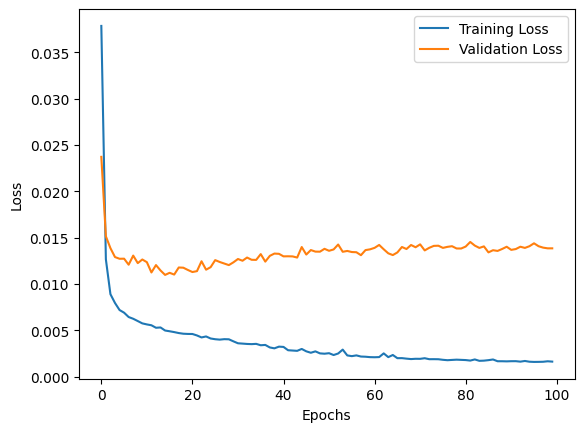

In [39]:
with tf.device('/CPU:0'):
    inputs = Input(shape=(INPUT_STEP, N_FEATURE))
    conv = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)

    encoder = LSTM(64, return_sequences=True)(conv)

    attention = Attention()([encoder, encoder])

    decoder = LSTM(64, return_sequences=True)(attention)

    gru1 = GRU(50, activation='relu', return_sequences=True)(decoder)

    dense1 = Dense(50, activation='relu')(gru1)
    dense2 = Dense(PREDICT_STEP)(dense1)

    model = Model(inputs=inputs, outputs=dense2)
    model.summary()
    model.compile(optimizer='adam', loss='mse')
    
    early_stopping = EarlyStopping(
        monitor='loss',
        patience=7,
        min_delta=0.00001,
        restore_best_weights=True
    )

    history = model.fit(
        X_train,
        y_train,
        verbose=1,
        epochs=100,
        batch_size=250,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

# plot loss & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(TRAINING_HISTORY_DIR)
plt.close()

model.save(MODEL_FILE_DIR)


In [40]:
# testing
model = load_model(MODEL_FILE_DIR)
loss = model.evaluate(X_test, y_test)

print("-" * 86)
print(f'Test Loss: {loss:.4f}')
print("-" * 86)

pred = model.predict(X_test)
X_test_reshaped = X_test[:, :, 0]
y_test_reshaped = np.reshape(y_test, (y_test.shape[0], y_test.shape[1]))

pred_data = np.concatenate(
    [scaler.inverse_transform(X_test_reshaped),
        scaler.inverse_transform(pred)],
    axis=-1
)
actual_data = np.concatenate(
    [scaler.inverse_transform(X_test_reshaped),
        scaler.inverse_transform(y_test_reshaped)],
    axis=-1
)

for i in range(actual_data.shape[0]):
    plt.figure(figsize=(16, 6))
    X = np.arange(1, actual_data.shape[1]+1, 1)
    y_pred = pred_data[i]
    y_actual = actual_data[i]
    plt.title(f"Time Series {i+1} prediction result")
    plt.plot(X, y_pred, label='Predict')
    plt.plot(X, y_actual, label='Actual')
    plt.ylim(0, 30)
    plt.xlabel('Time step')
    plt.ylabel('Usage (kWh)')
    plt.legend()
    plt.savefig(TEST_PLOT_DIR+f"Time_Series_{i+1}.png")
    plt.close()

  4/104 [>.............................] - ETA: 2s - loss: 0.0209 

2024-01-18 12:49:36.926931: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1080 Ti" frequency: 1582 num_cores: 28 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2883584 shared_memory_size_per_multiprocessor: 98304 memory_size: 10792206336 bandwidth: 484440000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


104/104 [==============================] - 3s 24ms/step - loss: 0.0315
--------------------------------------------------------------------------------------
Test Loss: 0.0315
--------------------------------------------------------------------------------------
  2/104 [..............................] - ETA: 5s 

2024-01-18 12:49:39.857782: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce GTX 1080 Ti" frequency: 1582 num_cores: 28 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 2883584 shared_memory_size_per_multiprocessor: 98304 memory_size: 10792206336 bandwidth: 484440000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


104/104 [==============================] - 3s 24ms/step
